# Exploration of the pictures dataset

Dans ce notebook sur l'exploration du dataset d'images d'entraînement, on va étudier les principales caractéristiques de ce dernier : valeurs manquantes, qualité des images, taille, etc.


In [1]:
from pathlib import Path
import concurrent
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np


# 1 - Build dataframe from basic image features

Comme les images sont incluses dans un dossier, on n'a pas directement de structure sous forme de dataframe ou autre. On va donc écrire une fonction qui permet de parcourir l'ensemble des images une par une et construit un dataframe à partir d'informations sur les images. Par ailleurs, on va paralléliser l'extraction d'informations pour réduire le temps de traitement.


In [ ]:
n_cores = 8  # set the number of available CPU cores

img_dir = Path("../../data/images/image_train/")  # the folder of the dataset
img_names = [img for img in img_dir.iterdir()] # get the names of every images in the folder


# processing for each image
def process_image(img_file) -> dict[str, ]:
    try:
        img = cv2.imread(str(img_file), cv2.IMREAD_UNCHANGED)
        if img is None:
            return None
        h, w = img.shape[:-1]
        np_img = img.astype(np.float64)
        avg, std = np.mean(np_img, axis=(0, 1)), np.std(np_img, axis=(0, 1))

        return {'img_id': img_file.stem,
                "width": w,
                "height": h,
                "memsize": img.nbytes,
                "avg_red_pixel": float(avg[0]),
                "stddev_red_pixel": float(std[0]),
                "avg_green_pixel": float(avg[1]),
                "stddev_green_pixel": float(std[1]),
                "avg_blue_pixel": float(avg[2]),
                "stddev_blue_pixel": float(std[2]),
                "avg_combined_pixel": float(np.mean(avg)),
                "stddev_combined_pixel": float(np.mean(std))}
    except Exception:
        return None

# loop for all images
def make_dataframe(img_names) -> pd.DataFrame:
    data = []
    errors = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_image, img): img for img in img_names}
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            result = future.result()
            img_file = futures[future]
            if result is not None:
                data.append(result)
            else:
                errors.append(img_file)
            print(f"\rProcessing images - {100 * (i+1) / len(img_names):.2f}%   ", end='')
    df = pd.DataFrame(data)
    print()
    return df, errors


In [10]:
# INFO: this cell may take a while to complete because of the number of images to process (CPU Intel i7 11700K : ~4min with 8 cores)
df, errors = make_dataframe(img_names)  # create the dataframe


Processing images - 100.00%   


In [12]:
print(errors)  # check if some image processing gone wrong


[]


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   img_id                 84916 non-null  object 
 1   width                  84916 non-null  int64  
 2   height                 84916 non-null  int64  
 3   memsize                84916 non-null  int64  
 4   avg_red_pixel          84916 non-null  float64
 5   stddev_red_pixel       84916 non-null  float64
 6   avg_green_pixel        84916 non-null  float64
 7   stddev_green_pixel     84916 non-null  float64
 8   avg_blue_pixel         84916 non-null  float64
 9   stddev_blue_pixel      84916 non-null  float64
 10  avg_combined_pixel     84916 non-null  float64
 11  stddev_combined_pixel  84916 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 7.8+ MB


In [15]:
df.head()


,img_id,width,height,memsize,avg_red_pixel,stddev_red_pixel,avg_green_pixel,stddev_green_pixel,avg_blue_pixel,stddev_blue_pixel,avg_combined_pixel,stddev_combined_pixel
0,image_1001455509_product_367180564,500,500,750000,143.514952,60.507068,152.662760,57.574376,160.743936,55.960091,152.307216,58.013845
1,image_1000293768_product_355549191,500,500,750000,132.684304,97.808740,137.639172,96.347057,146.466920,92.227603,138.930132,95.461133
2,image_1000089455_product_348990858,500,500,750000,177.126872,72.516040,184.711712,68.823657,192.365404,63.110157,184.734663,68.149951
3,image_1000969633_product_361840664,500,500,750000,186.263868,94.899799,184.384064,96.946045,182.610580,98.469488,184.419504,96.771777
4,image_1001605295_product_370765176,500,500,750000,225.997072,69.459138,227.326860,66.749911,237.202800,44.858580,230.175577,60.355876


# 2 - Exploration

Explorons ce nouveau dataset. Commençons par vérifier que toutes les images sont définies sur les $3$ canaux standards RGB.


In [19]:
df.isna().sum()


img_id                   0
width                    0
height                   0
memsize                  0
avg_red_pixel            0
stddev_red_pixel         0
avg_green_pixel          0
stddev_green_pixel       0
avg_blue_pixel           0
stddev_blue_pixel        0
avg_combined_pixel       0
stddev_combined_pixel    0
dtype: int64

Aucune valeur manquante n'est présente dans le dataframe, donc toutes les images sont définies en RGB.

Etudions maintenant la dimension des images.


In [20]:
df[['width', 'height', 'memsize']].value_counts()


width  height  memsize
500    500     750000     84916
Name: count, dtype: int64

Toutes les images ont la même dimension, et donc la même taille en mémoire. C'est une information qui nous épargne d'effectuer une uniformisation des tailles des images. On a aussi un contrôle sur la taille mémoire des images, donc on sait que chaque image devrait avoir une durée de manipulation (pré-traitement, entraînement des modèles, etc) *a priori* identique. Comme on a vérifié ces infos, on peut les retirer du dataframe.


In [21]:
df = df.drop(columns=['width', 'height', 'memsize'])


Notons que la taille des images amène une représentation matricielle de dimension $(500, 500, 3)$, c'est-à-dire que chaque image transmis à un modèle est une donnée de dimension $750\,000$. On est donc sur un problème de très grande dimension, nécessitant l'utilisation de modèles particulièrement bien adapté à ce genre de données. Potentiellement, on pourra considérer des techniques de réduction de dimension pour simplifier l'espace des données. On peut penser notamment à une réduction des canaux (passage RGB -> nuances de gris), des features selection par auto-encodeurs, ACP, etc.

Etudions plus en détail la répartition des pixels moyens sur l'ensemble du dataset.


[]

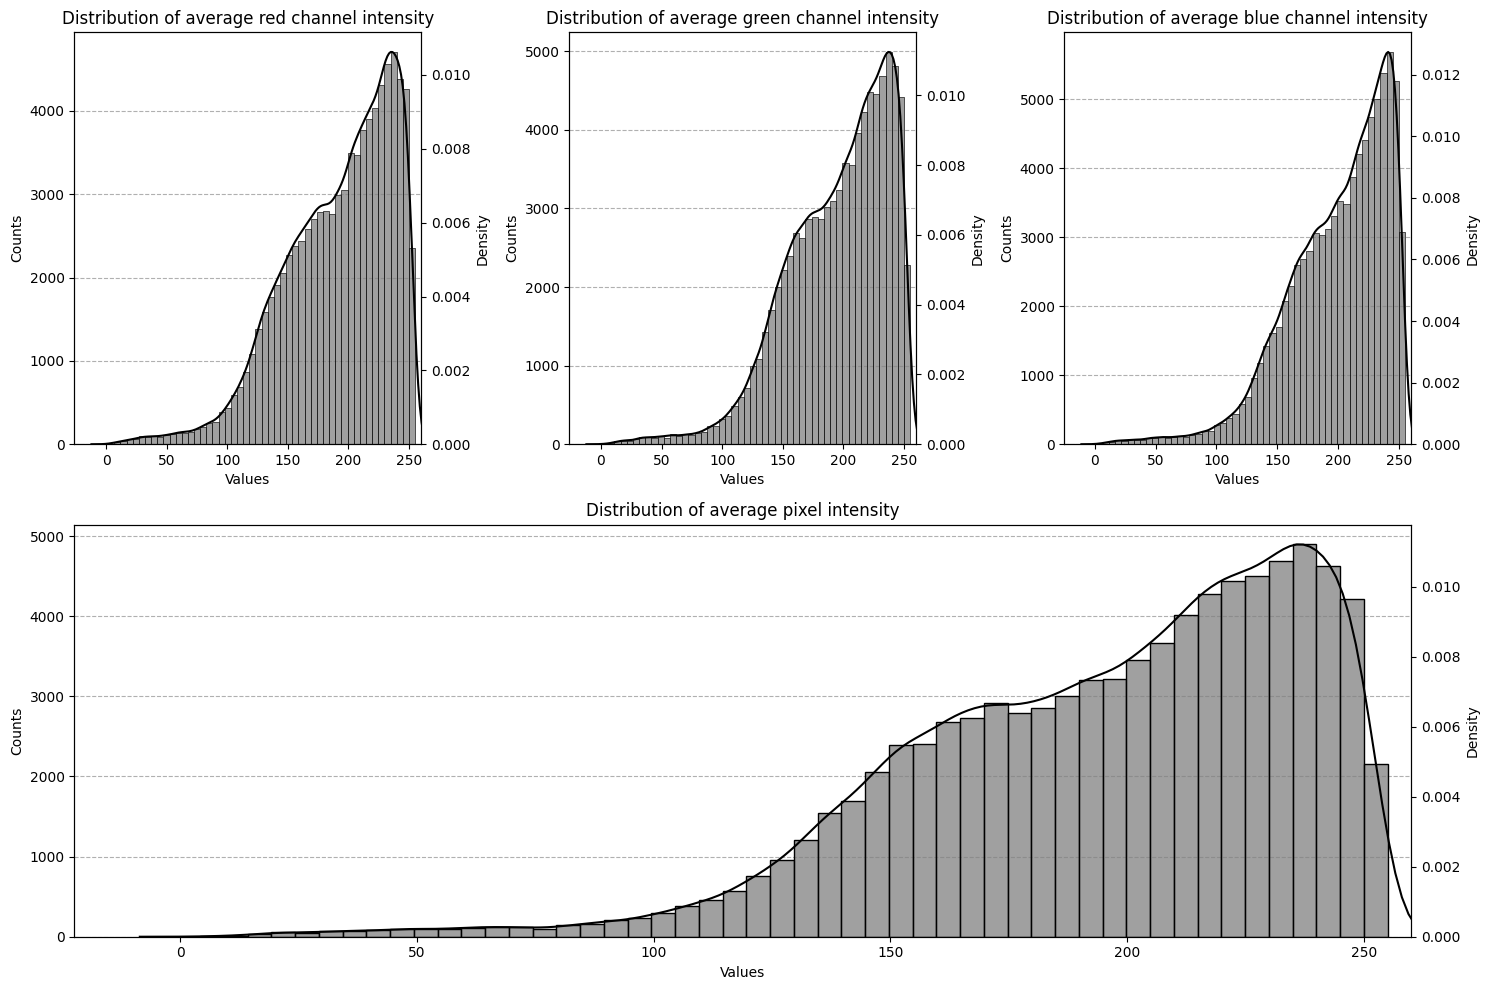

In [42]:
fig, ax = plt.subplot_mosaic([[1, 2, 3], [4, 4, 4]], figsize=(15, 10))

sns.histplot(df['avg_red_pixel'], bins=50, ax=ax[1], color='gray', zorder=2)
ax[1].set_ylabel('Counts')
xa = ax[1].twinx()
sns.kdeplot(df['avg_red_pixel'], ax=xa, color='black', zorder=2)
ax[1].set_xlabel('Values')
ax[1].set_xlim(right=260)
ax[1].grid(axis='y', linestyle='--')
ax[1].set_title('Distribution of average red channel intensity')

sns.histplot(df['avg_green_pixel'], bins=50, ax=ax[2], color='gray', zorder=2)
ax[2].set_ylabel('Counts')
xa = ax[2].twinx()
sns.kdeplot(df['avg_green_pixel'], ax=xa, color='black', zorder=2)
ax[2].set_xlabel('Values')
ax[2].set_xlim(right=260)
ax[2].grid(axis='y', linestyle='--')
ax[2].set_title('Distribution of average green channel intensity')

sns.histplot(df['avg_blue_pixel'], bins=50, ax=ax[3], color='gray', zorder=2)
ax[3].set_ylabel('Counts')
xa = ax[3].twinx()
sns.kdeplot(df['avg_blue_pixel'], ax=xa, color='black', zorder=2)
ax[3].set_xlabel('Values')
ax[3].set_xlim(right=260)
ax[3].grid(axis='y', linestyle='--')
ax[3].set_title('Distribution of average blue channel intensity')

sns.histplot(df['avg_combined_pixel'], bins=50, ax=ax[4], color='gray', zorder=2)
ax[4].set_ylabel('Counts')
xa = ax[4].twinx()
sns.kdeplot(df['avg_combined_pixel'], ax=xa, color='black', zorder=2)
ax[4].set_xlabel('Values')
ax[4].set_xlim(right=260)
ax[4].grid(axis='y', linestyle='--')
ax[4].set_title('Distribution of average pixel intensity')

plt.tight_layout()
plt.plot()


Aucune tendance particulière n'est visible sur les distributions. On peut confirmer le fait que dans l'ensemble, les images ont une intensité plutôt bonne (valeur du pixel moyen > $100$ dans la majorité des cas). On va rattacher les informations obtenues sur les images aux classes dans le but de déterminer si certaines classes ont certaines couleurs qui seraient prédominantes. On va importer les datasets correspondant et joindre le dataframe ci-dessus.


In [50]:
df_text = pd.read_csv('../../data/X_train.csv', index_col=0)[['productid', 'imageid']].copy(deep=True)

labels = pd.read_csv('../../data/Y_train.csv', index_col=0).rename(columns={'prdtypecode': 'labels'})

df_text = pd.concat([df_text, labels], axis=1)

df['productid'] = df['img_id'].apply(lambda s: s.split('_')[-1]).astype('int64')
df['imageid'] = df['img_id'].apply(lambda s: s.split('_')[1]).astype('int64')

df = df.merge(right=df_text, how='left', on=['productid', 'imageid'])  # merging the dataframes

df = df.drop(columns=['img_id'])

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avg_red_pixel          84916 non-null  float64
 1   stddev_red_pixel       84916 non-null  float64
 2   avg_green_pixel        84916 non-null  float64
 3   stddev_green_pixel     84916 non-null  float64
 4   avg_blue_pixel         84916 non-null  float64
 5   stddev_blue_pixel      84916 non-null  float64
 6   avg_combined_pixel     84916 non-null  float64
 7   stddev_combined_pixel  84916 non-null  float64
 8   productid              84916 non-null  int64  
 9   imageid                84916 non-null  int64  
 10  labels                 84916 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 7.1 MB


,avg_red_pixel,stddev_red_pixel,avg_green_pixel,stddev_green_pixel,avg_blue_pixel,stddev_blue_pixel,avg_combined_pixel,stddev_combined_pixel,productid,imageid,labels
0,143.514952,60.507068,152.662760,57.574376,160.743936,55.960091,152.307216,58.013845,367180564,1001455509,2583
1,132.684304,97.808740,137.639172,96.347057,146.466920,92.227603,138.930132,95.461133,355549191,1000293768,2403
2,177.126872,72.516040,184.711712,68.823657,192.365404,63.110157,184.734663,68.149951,348990858,1000089455,2280
3,186.263868,94.899799,184.384064,96.946045,182.610580,98.469488,184.419504,96.771777,361840664,1000969633,1320
4,225.997072,69.459138,227.326860,66.749911,237.202800,44.858580,230.175577,60.355876,370765176,1001605295,1281


Maintenant que l'on dispose des classes associées aux images, on va pouvoir faire des groupements dessus. Observons la distribution des valeurs des pixels moyen par canal et par groupe. Cela pourrait permettre de déterminer si il est nécessaire de conserver des images en RGB où si la coloration est insensible aux différentes classes.


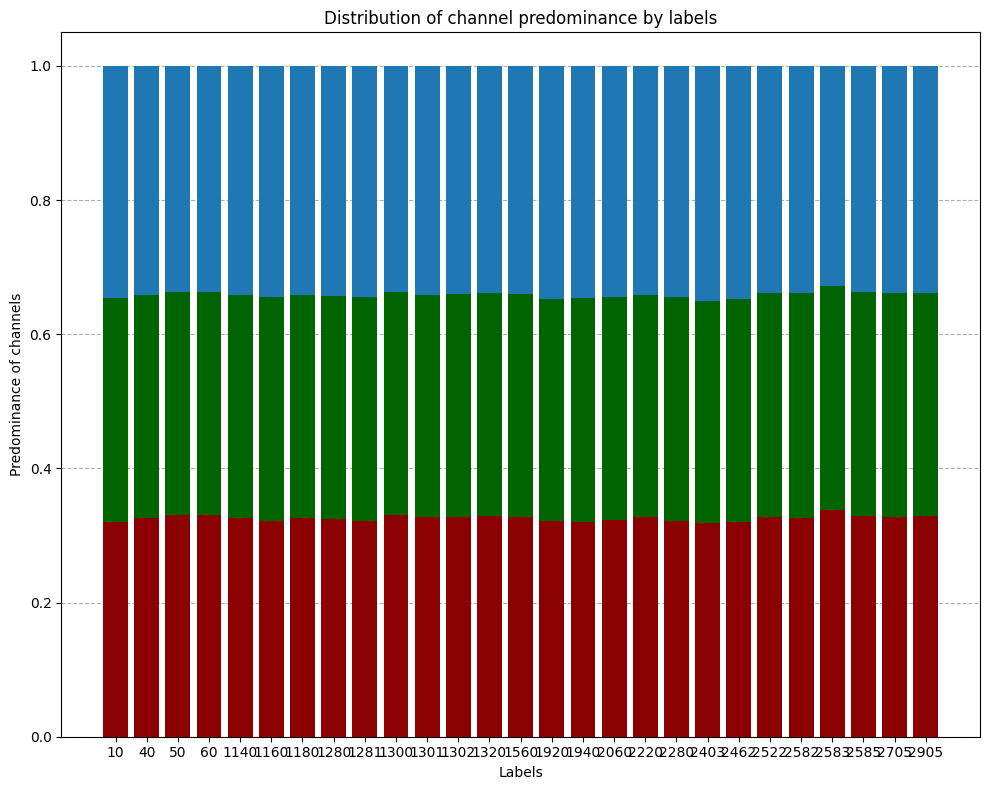

In [74]:
labels_group = df[['labels', 'avg_red_pixel', 'avg_green_pixel', 'avg_blue_pixel']].groupby('labels').agg('mean').reset_index()  # grouping by labels and aggregate with mean

# ratio of each channels for each label
labels_group['red_ratio'] = labels_group['avg_red_pixel'] / (labels_group['avg_red_pixel'] + labels_group['avg_green_pixel'] + labels_group['avg_blue_pixel'])
labels_group['green_ratio'] = labels_group['avg_green_pixel'] / (labels_group['avg_red_pixel'] + labels_group['avg_green_pixel'] + labels_group['avg_blue_pixel'])
labels_group['blue_ratio'] = labels_group['avg_blue_pixel'] / (labels_group['avg_red_pixel'] + labels_group['avg_green_pixel'] + labels_group['avg_blue_pixel'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
positions = range(27)

ax.bar(positions, labels_group['red_ratio'], color='darkred', tick_label=labels_group['labels'], zorder=2)
ax.bar(positions, labels_group['green_ratio'], bottom=labels_group['red_ratio'], color='darkgreen', tick_label=labels_group['labels'], zorder=2)
ax.bar(positions, labels_group['blue_ratio'], bottom=labels_group['red_ratio'] + labels_group['green_ratio'], tick_label=labels_group['labels'], zorder=2)

ax.set_xlabel('Labels')
ax.set_ylabel('Predominance of channels')
ax.set_title('Distribution of channel predominance by labels')
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()


A la vue de l'histogramme de prédominance ci-dessus, on ne peut pas conclure sur une caractérisation colorimétrique des différentes classes. On pourra donc considérer une transformation des images en nuances de gris, par exemple, pour réduire le poids des données (dimensions, taille mémoire, etc).


## 3 - Conclusion

On a vu dans ce notebook plusieurs éléments remarquables concernant le dataset d'images. Entre autres :
- Les images sont sous format RGB et standardisées en taille, leur dimension est $(500, 500, 3)$.
- Les modèles utilisés doivent donc supporter des données de très grande dimension.
- Les canaux RGB des images ne semblent pas caractériser les classes à prédire, on peut donc penser *a priori* à une réduction de dimension en transformant en nuances de gris les images -> dimension divisé par $3$.


## REMARQUE

*Extraction des valeurs de pixel en faisant la moyenne sur toute l'image, donc possiblement trop aggrégé d'où les résultats insensibles aux classes. Peut-être extraire une sous-image plutôt que juste la valeur moyenne du pixel par canal ?*
